# Notes for this revision

- Attempt to eliminate pitch acceleration predictions and just predict coefficients
- Initialize weights manually for hyper parameter optimization
- Predict all coefficients

In [108]:
import csv
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, BatchNormalization, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from scipy.signal import butter, filtfilt, welch
import os
from tensorflow.keras import backend as K
from control import matlab as MATLAB
import optuna


K.clear_session()

os.chdir('/home/coder/workspace/VanderWiel/Fennec2023/SystemID')
name = 'simulated_outputs.csv'

data = pd.read_csv(name)
    
print(data.shape)

(150000, 5)


In [109]:
# resetting RAM in gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [110]:
t = data.iloc[1:, 0].values
Vp = data.iloc[1:, 1].values
Vy = data.iloc[1:, 2].values
pitch = data.iloc[1:, 3].values
yaw = data.iloc[1:, 4].values

sampleRate = len(t)/t[-1]

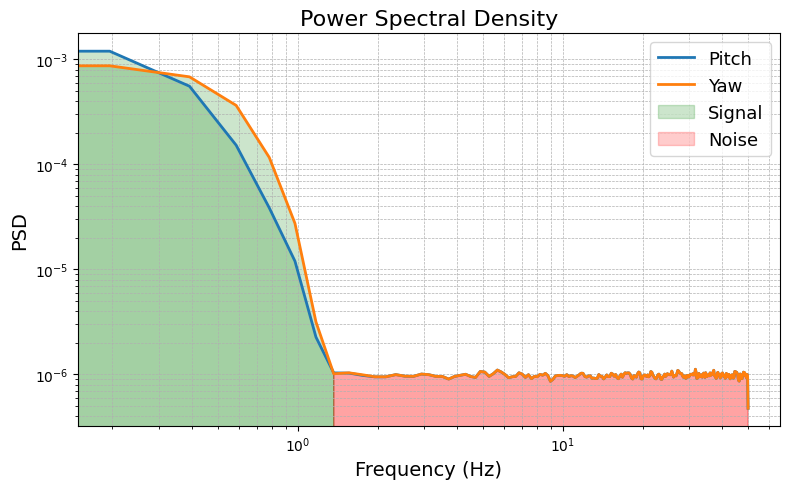

In [111]:
import matplotlib.pyplot as plt
from scipy.signal import welch

# Calculate PSD
p_freq, p_psd = welch(pitch, fs=sampleRate, nperseg=512)
y_freq, y_psd = welch(yaw, fs=sampleRate, nperseg=512)

# Plot PSD
fig, ax = plt.subplots(figsize=(8, 5))  

ax.loglog(p_freq, p_psd, label='Pitch', linewidth=2)  
ax.loglog(y_freq, y_psd, label='Yaw', linewidth=2)  

ax.set_xlabel('Frequency (Hz)', fontsize=14)  
ax.set_ylabel('PSD', fontsize=14)  
ax.set_title('Power Spectral Density', fontsize=16)  

# Enable minor ticks
ax.minorticks_on()

# Add circles
signal_freq_range = [0, 1.5]  # Define the frequency range for the signal
noise_freq_range = [1.33, 50]  # Define the frequency range for the noise

ax.fill_between(p_freq, p_psd, y2=0, where=(p_freq >= signal_freq_range[0]) & (p_freq <= signal_freq_range[1]), color='green', alpha=0.2, label='Signal')
ax.fill_between(p_freq, p_psd, y2=0, where=(y_freq >= noise_freq_range[0]) & (y_freq <= noise_freq_range[1]), color='red', alpha=0.2, label='Noise')
ax.fill_between(y_freq, y_psd, y2=0, where=(p_freq >= signal_freq_range[0]) & (p_freq <= signal_freq_range[1]), color='green', alpha=0.2)
ax.fill_between(y_freq, y_psd, y2=0, where=(y_freq >= noise_freq_range[0]) & (y_freq <= noise_freq_range[1]), color='red', alpha=0.2)

ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=13)  # Increase font size
plt.tight_layout()

# Save the modified plot
plt.savefig('modified_psd_plot.png')
plt.show()


In [112]:
def lowpass(order, highStop, sampleRate, data):
    '''
    The function uses a Butterworth low pass filter and returns the filtered time-series data

    :param order: order of the filter (higher order means faster roll off), int
    :param highStop: high frequency before the roll off starts, int
    :param sampleRate: sample rate at which the data was collected, int
    :param data: collected data, array_like
    '''
    b, a = butter(order, highStop, 'lowpass', fs=sampleRate)
    return filtfilt(b, a, data)


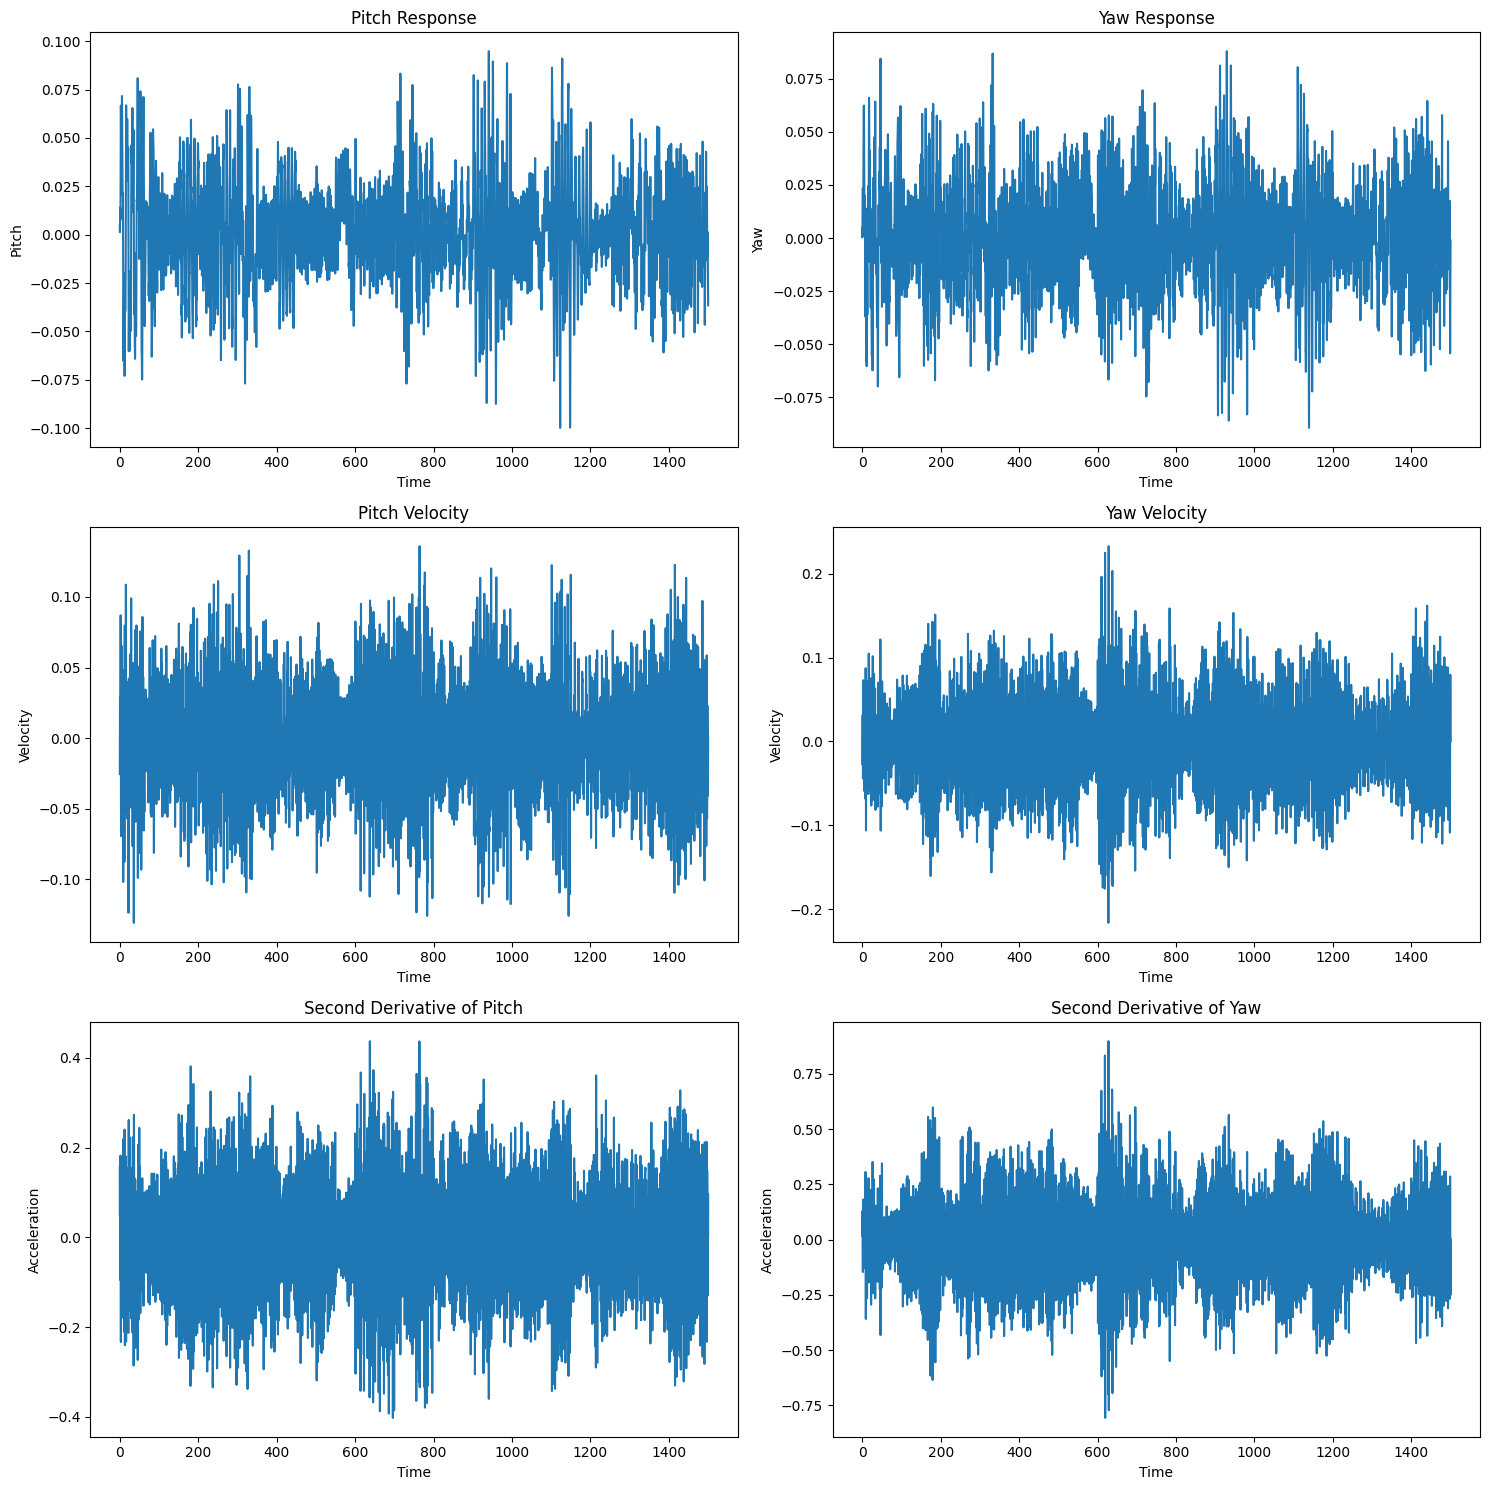

In [113]:
# Filter noise
order = 3
highStop = 1.25

pitch = lowpass(order, highStop, sampleRate, pitch)
yaw = lowpass(order, highStop, sampleRate, yaw)

# Compute velocity derivatives
tstep = t[2]-t[1]
pitch_velocity = np.array([np.diff(pitch, n=1)])
pitch_velocity = np.transpose(pitch_velocity)/tstep
pitch_velocity= np.append(pitch_velocity, 0)
yaw_velocity = np.array([np.diff(yaw, n=1)])
yaw_velocity = np.transpose(yaw_velocity)/tstep
yaw_velocity = np.append(yaw_velocity, 0)

# Compute acceleration derivatives
# We are computing accelerations becuase we don't trust the measured values are labeled correctly
d2pitchdt2 = np.array([np.diff(pitch_velocity, n=1)])
d2pitchdt2 = np.transpose(d2pitchdt2)/tstep
d2pitchdt2= np.append(d2pitchdt2, 0)
d2yawdt2 = np.array([np.diff(yaw_velocity, n=1)])
d2yawdt2 = np.transpose(d2yawdt2)/tstep
d2yawdt2 = np.append(d2yawdt2, 0)

# plotting as a data check
fig, axs = plt.subplots(3, 2, figsize=(15, 15))  # Adjust figsize as needed

# # Set common x-axis limits for all subplots
# for row in axs:
#     for ax in row:
#         ax.set_xlim([0, 50])

# Plot pitch response in the first subplot
axs[0, 0].plot(t, pitch)
axs[0, 0].set_title('Pitch Response')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Pitch')

# Plot pitch velocity in the second subplot
axs[1, 0].plot(t, pitch_velocity)
axs[1, 0].set_title('Pitch Velocity')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Velocity')

# Plot second derivative of pitch in the third subplot
axs[2, 0].plot(t, d2pitchdt2)
axs[2, 0].set_title('Second Derivative of Pitch')
axs[2, 0].set_xlabel('Time')
axs[2, 0].set_ylabel('Acceleration')
# axs[2, 0].set_ylim([-5,5])

# Plot yaw response in the fourth subplot
axs[0, 1].plot(t, yaw)
axs[0, 1].set_title('Yaw Response')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Yaw')

# Plot yaw velocity in the fifth subplot
axs[1, 1].plot(t, yaw_velocity)
axs[1, 1].set_title('Yaw Velocity')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Velocity')

# Plot second derivative of yaw in the sixth subplot
axs[2, 1].plot(t, d2yawdt2)
axs[2, 1].set_title('Second Derivative of Yaw')
axs[2, 1].set_xlabel('Time')
axs[2, 1].set_ylabel('Acceleration')
# axs[2, 1].set_ylim([-5,5])

# Automatically adjust subplot parameters to give specified padding
plt.tight_layout()


In [114]:
inputs = np.array([t, Vp, Vy, pitch, yaw, pitch_velocity, yaw_velocity]) # Everything in the order previously defined
inputs = np.transpose(inputs)

outputs = np.array([d2pitchdt2, d2yawdt2])
outputs = np.transpose(outputs)

print("Shape of inputs array:", inputs.shape)
print('Shape of outputs array:', outputs.shape)

# input_train, input_test, output_train, output_test = train_test_split(inputs, outputs, shuffle=False, test_size=0.25)
input_train, input_test, output_train, output_test = train_test_split(inputs, outputs, test_size=0.25, random_state=42, shuffle=False)


tf.random.set_seed(42)

model = Sequential([
    Dense(units=200, activation='tanh'),
    Dense(units=200, activation='tanh'),
    Dense(units=200, activation='tanh'),
    Dense(units=200, activation='tanh'),
    Dense(units=200, activation='tanh'),
    Dense(units=12, activation='linear')
])

optm = tf.keras.optimizers.Adam(learning_rate = 0.0009145733284081542)

Shape of inputs array: (149999, 7)
Shape of outputs array: (149999, 2)


In [115]:
def custom_loss(input_train, output_train, net, itr):
    # Convert inputs and outputs to tensors
    input_train = tf.convert_to_tensor(input_train, dtype=tf.float32)
    output_train = tf.convert_to_tensor(output_train, dtype=tf.float32)

    # Assign an array for the current set of network predictions
    # These are the coefficients that are going to be used in calculating eq. loss
    # and acceleration for collocation loss
    predictions = net(input_train)

   # unpack coefficients
    pred_coeff1 = net(input_train)[:,0]
    pred_coeff2 = net(input_train)[:,1]
    pred_coeff3 = net(input_train)[:,2]
    pred_coeff4 = net(input_train)[:,3]
    pred_coeff5 = net(input_train)[:,4]
    pred_coeff6 = net(input_train)[:,5]
    pred_coeff7 = net(input_train)[:,6]
    pred_coeff8 = net(input_train)[:,7]
    pred_coeff9 = net(input_train)[:,8]
    pred_coeff10 = net(input_train)[:,9]
    pred_coeff11 = net(input_train)[:,10]
    pred_coeff12 = net(input_train)[:,11]



    # calculate 1st and 2nd numerical derivatives of the coeffiecients
    grad1 = tf.experimental.numpy.diff(pred_coeff1)
    dgrad1 = tf.experimental.numpy.diff(grad1)
    grad2 = tf.experimental.numpy.diff(pred_coeff2)
    dgrad2 = tf.experimental.numpy.diff(grad2)
    grad3 = tf.experimental.numpy.diff(pred_coeff3)
    dgrad3 = tf.experimental.numpy.diff(grad3)
    grad4 = tf.experimental.numpy.diff(pred_coeff4)
    dgrad4 = tf.experimental.numpy.diff(grad4)

    grad5 = tf.experimental.numpy.diff(pred_coeff5)
    grad6 = tf.experimental.numpy.diff(pred_coeff6)
    grad7 = tf.experimental.numpy.diff(pred_coeff7)
    grad8 = tf.experimental.numpy.diff(pred_coeff8)
    grad9 = tf.experimental.numpy.diff(pred_coeff9)
    grad10 = tf.experimental.numpy.diff(pred_coeff10)
    grad11 = tf.experimental.numpy.diff(pred_coeff11)
    grad12 = tf.experimental.numpy.diff(pred_coeff12)



    # reshape coeffiecients and their derivatives
    pred_coeff1 = tf.expand_dims(pred_coeff1, axis=1)
    pred_coeff2 = tf.expand_dims(pred_coeff2, axis=1)
    pred_coeff3 = tf.expand_dims(pred_coeff3, axis=1)
    pred_coeff4 = tf.expand_dims(pred_coeff4, axis=1)
    pred_coeff5 = tf.expand_dims(pred_coeff5, axis=1)
    pred_coeff6 = tf.expand_dims(pred_coeff6, axis=1)
    pred_coeff7 = tf.expand_dims(pred_coeff7, axis=1)
    pred_coeff8 = tf.expand_dims(pred_coeff8, axis=1)
    pred_coeff9 = tf.expand_dims(pred_coeff9, axis=1)
    pred_coeff10 = tf.expand_dims(pred_coeff10, axis=1)
    pred_coeff11 = tf.expand_dims(pred_coeff11, axis=1)
    pred_coeff12 = tf.expand_dims(pred_coeff12, axis=1)



    grad1 = tf.expand_dims(grad1, axis=1)
    dgrad1 = tf.expand_dims(dgrad1, axis=1)
    grad2 = tf.expand_dims(grad2, axis=1)
    dgrad2 = tf.expand_dims(dgrad2, axis=1)
    grad3 = tf.expand_dims(grad3, axis=1)
    dgrad3 = tf.expand_dims(dgrad3, axis=1)
    grad4 = tf.expand_dims(grad4, axis=1)
    dgrad4 = tf.expand_dims(dgrad4, axis=1)

    grad5 = tf.expand_dims(grad5, axis=1)
    grad6 = tf.expand_dims(grad6, axis=1)
    grad7 = tf.expand_dims(grad7, axis=1)
    grad8 = tf.expand_dims(grad8, axis=1)
    grad9 = tf.expand_dims(grad9, axis=1)
    grad10 = tf.expand_dims(grad10, axis=1)
    grad11 = tf.expand_dims(grad11, axis=1)
    grad12 = tf.expand_dims(grad12, axis=1)



    # Getting variables ready for equation loss
    theta = input_train[:,3] # theta = yaw_response
    theta = tf.expand_dims(theta, axis=1)
    dtheta = input_train[:,5] # dtheta = yaw_velocity
    dtheta = tf.expand_dims(dtheta, axis=1)
    psi = input_train[:,4]
    psi = tf.expand_dims(psi, axis=1)
    dpsi = input_train[:,6]
    dpsi = tf.expand_dims(dpsi, axis=1)
    Vp = input_train[:,1] # 
    Vp = tf.expand_dims(Vp, axis=1) 
    Vy = input_train[:,2]
    Vy = tf.expand_dims(Vy, axis=1)
    
    # reshape pitch and yaw accelerations
    pitch_accel = tf.expand_dims(output_train[:,0], axis=1)
    yaw_accel = tf.expand_dims(output_train[:,1], axis=1)

    
    # Compute L_eq: Equation Loss
    # This is based on the state space model of the Quanser
    # L_eq1 = tf.reduce_mean(tf.square(pred_coeff1*theta+pred_coeff2*dtheta+pred_coeff3*Vp+pred_coeff4*Vy-pitch_accel)) # Voltage is in Volts
    # L_eq2 = tf.reduce_mean(tf.square(pred_coeff5*dpsi+pred_coeff6*Vp+pred_coeff7*Vy-yaw_accel))

    L_eq1 = tf.reduce_mean(tf.square(pred_coeff1*theta + pred_coeff2*psi + pred_coeff3*dtheta + pred_coeff4*dpsi + pred_coeff5*Vp + pred_coeff6*Vy - pitch_accel))
    L_eq2 = tf.reduce_mean(tf.square(pred_coeff7*theta + pred_coeff8*psi + pred_coeff9*dtheta + pred_coeff10*dpsi + pred_coeff11*Vp + pred_coeff12*Vy - yaw_accel))

    # Gradient loss: trying to force the coefficients to be constant
    L_gr1 = tf.reduce_mean(tf.square(grad1 - 0)) #+ tf.reduce_mean(tf.square(dgrad1 - 0))
    L_gr2 = tf.reduce_mean(tf.square(grad2 - 0)) #+ tf.reduce_mean(tf.square(dgrad2 - 0))
    L_gr3 = tf.reduce_mean(tf.square(grad3 - 0)) #+ tf.reduce_mean(tf.square(dgrad3 - 0))
    L_gr4 = tf.reduce_mean(tf.square(grad4 - 0)) #+ tf.reduce_mean(tf.square(dgrad4 - 0))
    L_gr5 = tf.reduce_mean(tf.square(grad5 - 0))
    L_gr6 = tf.reduce_mean(tf.square(grad6 - 0))
    L_gr7 = tf.reduce_mean(tf.square(grad7 - 0))
    L_gr8 = tf.reduce_mean(tf.square(grad8 - 0))
    L_gr9 = tf.reduce_mean(tf.square(grad9 - 0))
    L_gr10 = tf.reduce_mean(tf.square(grad10 - 0))
    L_gr11 = tf.reduce_mean(tf.square(grad11 - 0))
    L_gr12 = tf.reduce_mean(tf.square(grad12 - 0))

    L_gr = L_gr1 + L_gr2 + L_gr3 + L_gr4 + L_gr5 + L_gr6 + L_gr7 + L_gr8 + L_gr9 + L_gr10 + L_gr11 + L_gr12

    # Adjusting loss component weights trying to make them roughly equal
    # Automatically adjust the weights after the first run
    # if itr == 0:
    #     global L_eq_norm, L_gr_norm, L_c_norm
    #     L_eq_norm = L_eq
    #     L_gr_norm = L_gr

    # L_eq = L_eq/L_eq_norm
    # L_gr = L_gr/L_gr_norm

    L_total = L_eq1 + L_eq2 + L_gr
    

    return L_total

In [116]:
def nrmse(actual_values, predicted_values):
    """
    Calculate Normalized Root Mean Squared Error (NRMSE) for regression. Normalized over the range of the target variable
    In this case it's the range of the pitch acceleration data

    Parameters:
    - actual_values: NumPy array or list of actual values.
    - predicted_values: NumPy array or list of predicted values.

    Returns:
    - nrmse: Normalized Root Mean Squared Error.
    """
    actual_values = np.array(actual_values).flatten()
    predicted_values = np.array(predicted_values).flatten()

    if len(actual_values) != len(predicted_values):
        raise ValueError("Length of actual_values and predicted_values must be the same.")

    # Calculate RMSE
    rmse = np.sqrt(np.mean((actual_values - predicted_values) ** 2))

    # Calculate the range of the target variable
    target_range = np.max(actual_values) - np.min(actual_values)

    # Calculate NRMSE
    nrmse = (rmse / target_range) * 100 # Expressed as a percentage

    return nrmse


0 :  0.016030753
50 :  0.0041105924


Text(0.5, 1.0, 'Training loss per epoch')

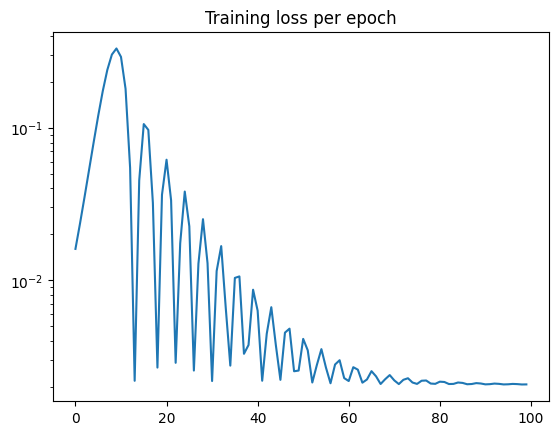

In [130]:
# Training loop

train_loss_record = []
for itr in range(100):
    with tf.GradientTape() as tape:
        train_loss = custom_loss(input_train, output_train, model, itr)
        train_loss_record.append(train_loss)
        grad_w = tape.gradient(train_loss, model.trainable_variables)
        optm.apply_gradients(zip(grad_w, model.trainable_variables))

    if itr % 50 == 0:
        print(itr, ': ', train_loss.numpy())

plt.semilogy(train_loss_record)
# plt.plot(train_loss_record)
plt.title('Training loss per epoch')


In [118]:
# model.save('synthetic_uncontrolled_model.h5')

   1/1172 [..............................] - ETA: 16s

1172/1172 [==============================] - 1s 1ms/step


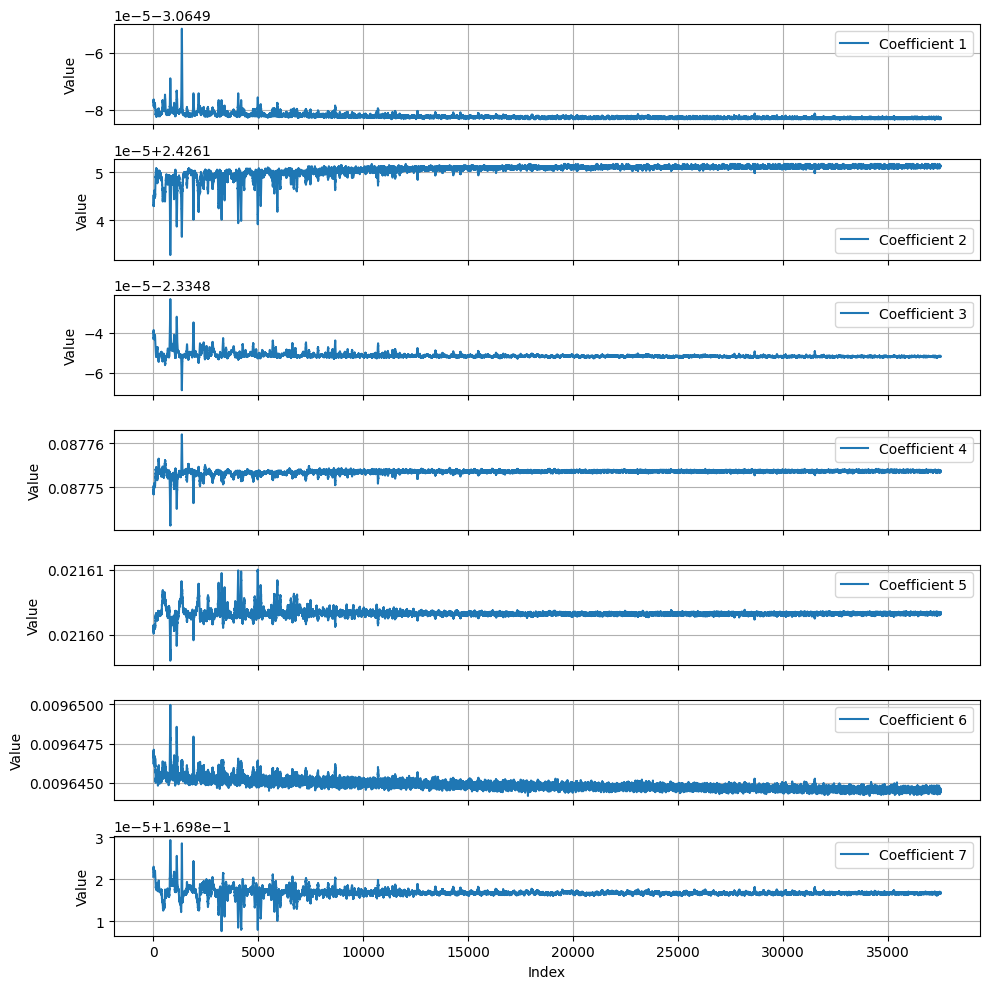

In [131]:
pitch_predictions_fnn = model.predict(input_test)

coeff1t = pitch_predictions_fnn[:, 0]
coeff2t = pitch_predictions_fnn[:, 1]
coeff3t = pitch_predictions_fnn[:, 2]
coeff4t = pitch_predictions_fnn[:, 3]
coeff5t = pitch_predictions_fnn[:, 4]
coeff6t = pitch_predictions_fnn[:, 5]
coeff7t = pitch_predictions_fnn[:, 6]


# Create a figure and subplots
fig, axes = plt.subplots(7, 1, figsize=(10, 10), sharex=True)

coeffs = [-0.321, -0.086, 0.023, 0.0099, -0.08067, -0.02244, 0.04291]
# Plot each coefficient on its own axis
for i, coeff in enumerate([coeff1t, coeff2t, coeff3t, coeff4t, coeff5t, coeff6t, coeff7t]):
    axes[i].plot(coeff, label=f'Coefficient {i+1}')
    # axes[i].plot([0,len(coeff)],[coeffs[i],coeffs[i]])
    axes[i].set_ylabel('Value')
    axes[i].legend()
    axes[i].grid()


# Set common xlabel
axes[-1].set_xlabel('Index')

# Adjust layout
plt.tight_layout()


In [132]:
# Making Predictions
coeff1 = np.mean(pitch_predictions_fnn[:,0])
coeff2 = np.mean(pitch_predictions_fnn[:,1])
coeff3 = np.mean(pitch_predictions_fnn[:,2])
coeff4 = np.mean(pitch_predictions_fnn[:,3])
coeff5 = np.mean(pitch_predictions_fnn[:,4])
coeff6 = np.mean(pitch_predictions_fnn[:,5])
coeff7 = np.mean(pitch_predictions_fnn[:,6])
coeff8 = np.mean(pitch_predictions_fnn[:,7])
coeff9 = np.mean(pitch_predictions_fnn[:,8])
coeff10 = np.mean(pitch_predictions_fnn[:,9])
coeff11 = np.mean(pitch_predictions_fnn[:,10])
coeff12 = np.mean(pitch_predictions_fnn[:,11])
print(coeff1, -3.06641354)
print(coeff2, 2.47354042)
print(coeff3, -2.35668236)
print(coeff4, 0.03990896)
print(coeff5, 0.02316596)
print(coeff6, 0.00988703)
print(coeff7, 0.16128203)
print(coeff8, -6.49041519)
print(coeff9, 0.06875182)
print(coeff10, -2.89607807)
print(coeff11, -0.02244125)
print(coeff12, 0.04291273)

-3.0649824 -3.06641354
2.4261506 2.47354042
-2.3348513 -2.35668236
0.08775346 0.03990896
0.021603305 0.02316596
0.009644874 0.00988703
0.16981676 0.16128203
-6.4710956 -6.49041519
0.14223637 0.06875182
-2.8988938 -2.89607807
-0.021665018 -0.02244125
0.04084075 0.04291273


In [133]:
from control import matlab as MATLAB

# AERO-2 MIMO system

# Moment of inertia about pitch-axis (kg-m^2)
Jp = 0.0232  # from CAD: 23188500.45 g-mm^2

# Moment of inertia about pitch-axis (kg-m^2)
Jy = 0.0238  # from CAD: 23810415.95 g-mm^2;

Dt = 0.16743  # distance from pivot to center of rotor/propeller (m)

# Experiment Pitch Parameters
Ksp = 0.00744  # Stiffness (N-m/(rad))
Dp = 0.00199  # Damping (N-m/(rad/s))
Kpp = 0.00321  # Pitch thrust gain (N/V)
Kpy = 0.00137  # Pitch from yaw thrust gain (N/V)

# Experimental Yaw Parameters
Dy = 0.00192  # Damping (N-m/(rad/s))
Kyy = 0.00610  # Yaw thrust gain Thrust (N/V)
Kyp = -0.00319  #  Yaw from pitch thrust gain (N/V)


# Set up state-space system
A = [[0, 0, 1, 0],
     [0, 0, 0, 1],
     [-Ksp/Jp, 0, -Dp/Jp, 0],
     [0, 0, 0, -Dy/Jy]]

A_est = [[0, 0, 1, 0],
     [0, 0, 0, 1],
     [coeff1, coeff2, coeff3, coeff4],
     [coeff7, coeff8, coeff9, coeff10]]

B = [[0, 0],
     [0, 0],
     [Kpp*Dt/Jp, Kpy*Dt/Jp],
     [Kyp*Dt/Jy, Kyy*Dt/Jy]]  

B_est = [[0, 0],
     [0, 0],
     [coeff5, coeff6],
     [coeff11, coeff12]]

C = [[1, 0, 0, 0],
     [0, 1, 0, 0]]

D = [[0, 0],
     [0, 0]]

K = np.array([[98.2088,-140.0645,80.7,-24.3],[47.6,78.0,40.6,52.9]])

Actrl = A-np.matmul(B,K)

AERO1 = MATLAB.ss(Actrl, B, C, D)
AERO_uncontrolled = MATLAB.ss(A, B, C, D)
AERO2 = MATLAB.ss(A_est,B_est,C,D)

print(AERO1)
# print(AERO2)

<LinearIOSystem>: sys[30]
Inputs (2): ['u[0]', 'u[1]']
Outputs (2): ['y[0]', 'y[1]']
States (4): ['x[0]', 'x[1]', 'x[2]', 'x[3]']

A = [[ 0.          0.          1.          0.        ]
     [ 0.          0.          0.          1.        ]
     [-3.06641354  2.47354042 -2.35668236  0.03990896]
     [ 0.16128203 -6.49041519  0.06875182 -2.89607807]]

B = [[ 0.          0.        ]
     [ 0.          0.        ]
     [ 0.02316596  0.00988703]
     [-0.02244125  0.04291273]]

C = [[1. 0. 0. 0.]
     [0. 1. 0. 0.]]

D = [[0. 0.]
     [0. 0.]]



In [134]:

error1 = np.abs(((Actrl[2,0]) - coeff1)/(Actrl[2,0])) * 100
error2 = np.abs(((Actrl[2,1]) - coeff2)/(Actrl[2,1])) * 100
error3 = np.abs(((Actrl[2,2]) - coeff3)/(Actrl[2,2])) * 100
error4 = np.abs(((Actrl[2,3]) - coeff4)/(Actrl[2,3])) * 100
error5 = np.abs(((B[2][0]) - coeff5)/(B[2][0])) * 100
error6 = np.abs(((B[2][1]) - coeff6)/(B[2][1])) * 100
error7 = np.abs(((Actrl[3,0]) - coeff7)/(Actrl[3,0])) * 100
error8 = np.abs(((Actrl[3,1]) - coeff8)/(Actrl[3,1])) * 100
error9 = np.abs(((Actrl[3,2]) - coeff9)/(Actrl[3,2])) * 100
error10 = np.abs(((Actrl[3,3]) - coeff10)/(Actrl[3,3])) * 100
error11 = np.abs(((B[3][0]) - coeff11)/(B[3][0])) * 100
error12 = np.abs(((B[3][1]) - coeff12)/(B[3][1])) * 100





# Round each error to an integer
errors = (error1, error2, error3, error4, error5, error6, error7, error8, error9, error10, error11, error12)
rounded_errors = [round(error,3) for error in (error1, error2, error3, error4, error5, error6, error7, error8, error9, error10, error11, error12)]

# Create messages for each error
error_messages = [f"Error {i+1}: {rounded_errors[i]}%" for i in range(len(rounded_errors))]

# Print the error messages
aggragate = 0
for i, message in enumerate(error_messages):
    print(message)
    aggragate += errors[i]

print('Average Error:', round(aggragate/len(errors),3), '%')

Error 1: 0.047%
Error 2: 1.916%
Error 3: 0.926%
Error 4: 119.884%
Error 5: 6.745%
Error 6: 2.449%
Error 7: 5.292%
Error 8: 0.298%
Error 9: 106.884%
Error 10: 0.097%
Error 11: 3.459%
Error 12: 4.828%
Average Error: 21.069 %


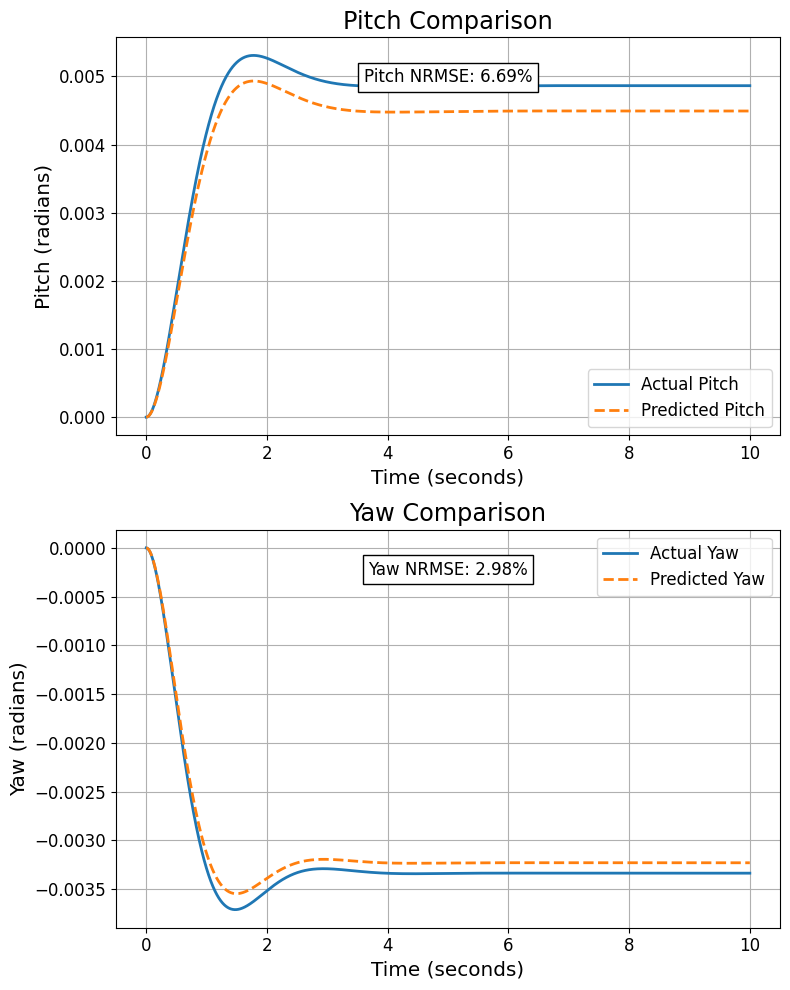

0.004863101314253687 -0.0033367542651888786


In [135]:
# Define shape and time array
shape = (10000,)
time = np.linspace(0, 10, shape[0])

# Create inputs Vp and Vy
Vp = np.zeros(shape)
Vp[1:] = 1
Vy = np.zeros(shape)
Vy[1:] = 0

# Combine inputs into a single array
U = np.array([Vp, Vy]).T

# Run simulations using lsim
yout1, T1, xout1 = MATLAB.lsim(AERO1, U, time, 0)
yout2, T2, xout2 = MATLAB.lsim(AERO2, U, time, 0)

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))  # Vertical stacking

# Plot actual and predicted pitch
ax1.plot(T1, yout1[:, 0], label='Actual Pitch', linewidth=2)
ax1.plot(T2, yout2[:, 0], label='Predicted Pitch', linewidth=2, linestyle='--')
ax1.legend(loc='best', fontsize='large')
ax1.set_xlabel('Time (seconds)', fontsize='x-large')
ax1.set_ylabel('Pitch (radians)', fontsize='x-large')
ax1.set_title('Pitch Comparison', fontsize='xx-large')
ax1.grid(True)
ax1.tick_params(axis='both', which='major', labelsize='large')

# Calculate and display Pitch NRMSE
pitch_nrmse = nrmse(yout1[:, 0], yout2[:, 0])
ax1.text(0.5, 0.9, f'Pitch NRMSE: {pitch_nrmse:.2f}%', ha='center', va='center', fontsize='large', transform=ax1.transAxes, bbox=dict(facecolor='white', edgecolor='black'))

# Plot actual and predicted yaw
ax2.plot(T1, yout1[:, 1], label='Actual Yaw', linewidth=2)
ax2.plot(T2, yout2[:, 1], label='Predicted Yaw', linewidth=2, linestyle='--')
ax2.legend(loc='best', fontsize='large')
ax2.set_xlabel('Time (seconds)', fontsize='x-large')
ax2.set_ylabel('Yaw (radians)', fontsize='x-large')
ax2.set_title('Yaw Comparison', fontsize='xx-large')
ax2.grid(True)
ax2.tick_params(axis='both', which='major', labelsize='large')

# Calculate and display Yaw NRMSE
yaw_nrmse = nrmse(yout1[:, 1], yout2[:, 1])
ax2.text(0.5, 0.9, f'Yaw NRMSE: {yaw_nrmse:.2f}%', ha='center', va='center', fontsize='large', transform=ax2.transAxes, bbox=dict(facecolor='white', edgecolor='black'))

plt.tight_layout()
plt.show()

print(yout1[:, 0][-1], yout1[:, 1][-1])


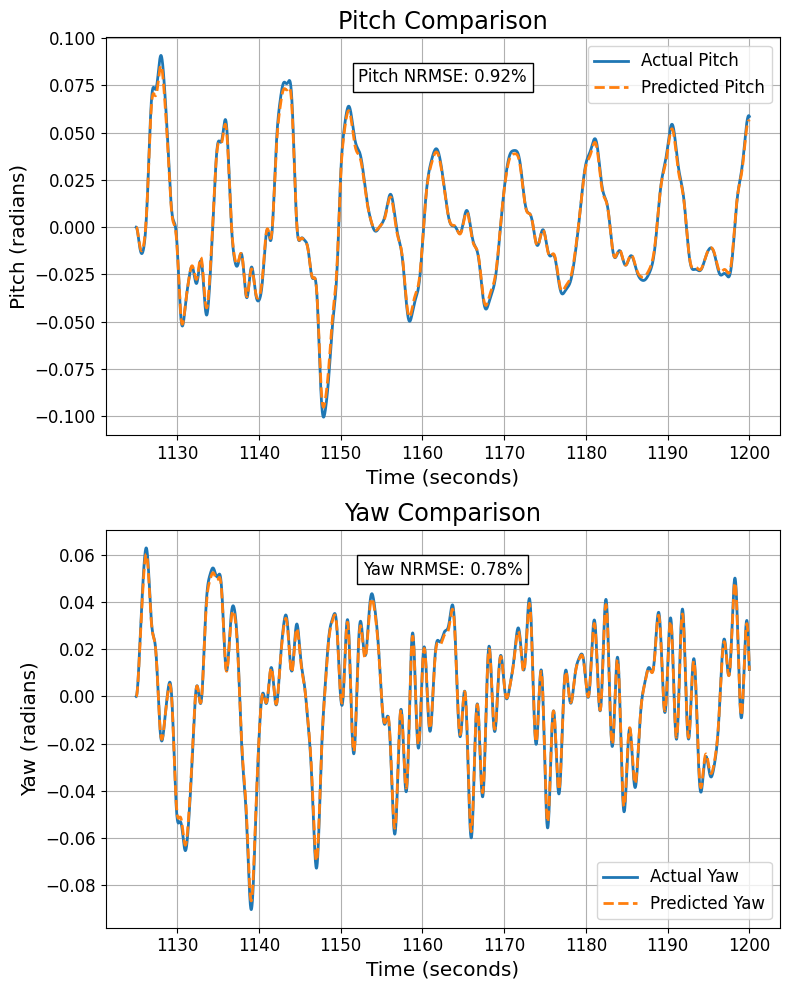

In [136]:
t_train = input_test[:,0]
Vp_train = input_test[:,1]
Vy_train = input_test[:,2]


cutoff = -30000
t_train = t_train[0:cutoff]
Vp_train = Vp_train[0:cutoff]
Vy_train = Vy_train[0:cutoff]

# Combine inputs into a single array
U = np.array([Vp_train, Vy_train]).T

# Run simulations using lsim
yout1, T1, xout1 = MATLAB.lsim(AERO1, U, t_train, 0)
yout2, T2, xout2 = MATLAB.lsim(AERO2, U, t_train, 0)

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))  # Vertical stacking

# # Set common x-axis limits for both axes
# common_xlim = (2000, 2200) 
# ax1.set_xlim(common_xlim)
# ax2.set_xlim(common_xlim)

# Plot actual and predicted pitch
ax1.plot(T1, yout1[:, 0], label='Actual Pitch', linewidth=2)
ax1.plot(T2, yout2[:, 0], label='Predicted Pitch', linewidth=2, linestyle='--')
ax1.legend(loc='best', fontsize='large')
ax1.set_xlabel('Time (seconds)', fontsize='x-large')
ax1.set_ylabel('Pitch (radians)', fontsize='x-large')
ax1.set_title('Pitch Comparison', fontsize='xx-large')
ax1.grid(True)
ax1.tick_params(axis='both', which='major', labelsize='large')

# Calculate and display Pitch NRMSE
pitch_nrmse = nrmse(yout1[:, 0], yout2[:, 0])
ax1.text(0.5, 0.9, f'Pitch NRMSE: {pitch_nrmse:.2f}%', ha='center', va='center', fontsize='large', transform=ax1.transAxes, bbox=dict(facecolor='white', edgecolor='black'))

# Plot actual and predicted yaw
ax2.plot(T1, yout1[:, 1], label='Actual Yaw', linewidth=2)
ax2.plot(T2, yout2[:, 1], label='Predicted Yaw', linewidth=2, linestyle='--')
ax2.legend(loc='best', fontsize='large')
ax2.set_xlabel('Time (seconds)', fontsize='x-large')
ax2.set_ylabel('Yaw (radians)', fontsize='x-large')
ax2.set_title('Yaw Comparison', fontsize='xx-large')
ax2.grid(True)
ax2.tick_params(axis='both', which='major', labelsize='large')

# Calculate and display Yaw NRMSE
yaw_nrmse = nrmse(yout1[:, 1], yout2[:, 1])
ax2.text(0.5, 0.9, f'Yaw NRMSE: {yaw_nrmse:.2f}%', ha='center', va='center', fontsize='large', transform=ax2.transAxes, bbox=dict(facecolor='white', edgecolor='black'))

plt.tight_layout()
plt.show()

Training the model on real (nonsynthetic) Data

In [125]:
loaded_model = tf.keras.models.load_model('synthetic_model.h5')

os.chdir('/home/coder/workspace/VanderWiel/Fennec2023/SystemID/')
name = 'aero2_no_control.csv'
data = pd.read_csv(name)


# end = 300
end = len(data)
t = data.iloc[1:,0].values[0:end]
t = np.linspace(t[0],t[-1],len(t))
time = np.linspace(0, t[-1], len(t))[0:end]
Vp = data.iloc[1:,1].values[0:end]
Vy = data.iloc[1:,2].values[0:end]
pitch = data.iloc[1:,3].values[0:end]
yaw = data.iloc[1:,4].values[0:end]
sampleRate = len(t)/t[-1]

order = 3
highStop = 2

pitch_filt = lowpass(order, highStop, sampleRate, pitch)
yaw_filt = lowpass(order, highStop, sampleRate, yaw)

tstep = t[2]-t[1]
pitch_velocity = np.array([np.diff(pitch_filt, n=1)])
pitch_velocity = np.transpose(pitch_velocity)/tstep
pitch_velocity = np.append(pitch_velocity, 0)
yaw_velocity = np.array([np.diff(yaw_filt, n=1)])
yaw_velocity = np.transpose(yaw_velocity)/tstep
yaw_velocity = np.append(yaw_velocity, 0)

inputs = np.array([t, Vp, Vy, pitch, yaw, pitch_velocity, yaw_velocity]) # Everything in the order previously defined
inputs = np.transpose(inputs)


pred = model.predict(inputs)



 1/39 [..............................] - ETA: 0s

39/39 [==============================] - 0s 1ms/step


Error 1: 26.903%
Error 2: 17.54%
Error 3: 25.866%
Error 4: 286.859%
Error 5: 0.109%
Error 6: 48.138%
Error 7: 30.542%
Error 8: 18.794%
Error 9: 295.969%
Error 10: 16.41%
Error 11: 262.847%
Error 12: 35.777%
Average Error: 88.813 %


-2.2414682 -3.06641354
2.0396905 2.47354042
-1.747099 -2.35668236
0.15439145 0.03990896
0.023140596 0.02316596
0.005127602 0.00988703
0.2105414 0.16128203
-5.2706103 -6.49041519
-0.13473232 0.06875182
-2.420845 -2.89607807
0.03654487 -0.02244125
0.027559726 0.04291273
[ 0.1069      0.3145     -0.01395992  0.0137472 ]


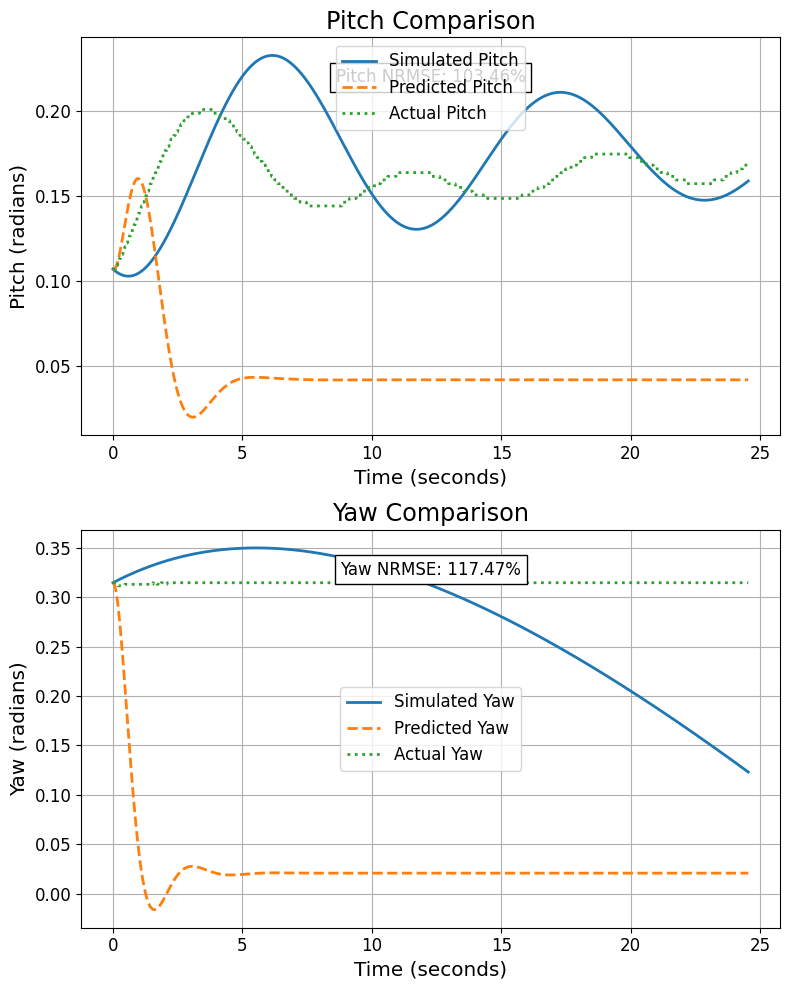

In [126]:

coeff1 = np.mean(pred[:,0])
coeff2 = np.mean(pred[:,1])
coeff3 = np.mean(pred[:,2])
coeff4 = np.mean(pred[:,3])
coeff5 = np.mean(pred[:,4])
coeff6 = np.mean(pred[:,5])
coeff7 = np.mean(pred[:,6])
coeff8 = np.mean(pred[:,7])
coeff9 = np.mean(pred[:,8])
coeff10 = np.mean(pred[:,9])
coeff11 = np.mean(pred[:,10])
coeff12 = np.mean(pred[:,11])

error1 = np.abs(((Actrl[2,0]) - coeff1)/(Actrl[2,0])) * 100
error2 = np.abs(((Actrl[2,1]) - coeff2)/(Actrl[2,1])) * 100
error3 = np.abs(((Actrl[2,2]) - coeff3)/(Actrl[2,2])) * 100
error4 = np.abs(((Actrl[2,3]) - coeff4)/(Actrl[2,3])) * 100
error5 = np.abs(((B[2][0]) - coeff5)/(B[2][0])) * 100
error6 = np.abs(((B[2][1]) - coeff6)/(B[2][1])) * 100
error7 = np.abs(((Actrl[3,0]) - coeff7)/(Actrl[3,0])) * 100
error8 = np.abs(((Actrl[3,1]) - coeff8)/(Actrl[3,1])) * 100
error9 = np.abs(((Actrl[3,2]) - coeff9)/(Actrl[3,2])) * 100
error10 = np.abs(((Actrl[3,3]) - coeff10)/(Actrl[3,3])) * 100
error11 = np.abs(((B[3][0]) - coeff11)/(B[3][0])) * 100
error12 = np.abs(((B[3][1]) - coeff12)/(B[3][1])) * 100


# Round each error to an integer
errors = (error1, error2, error3, error4, error5, error6, error7, error8, error9, error10, error11, error12)
rounded_errors = [round(error,3) for error in (error1, error2, error3, error4, error5, error6, error7, error8, error9, error10, error11, error12)]

# Create messages for each error
error_messages = [f"Error {i+1}: {rounded_errors[i]}%" for i in range(len(rounded_errors))]

# Print the error messages
aggragate = 0
for i, message in enumerate(error_messages):
    print(message)
    aggragate += errors[i]

print('Average Error:', round(aggragate/len(errors),3), '%')
print('\n')
print(coeff1, -3.06641354)
print(coeff2, 2.47354042)
print(coeff3, -2.35668236)
print(coeff4, 0.03990896)
print(coeff5, 0.02316596)
print(coeff6, 0.00988703)
print(coeff7, 0.16128203)
print(coeff8, -6.49041519)
print(coeff9, 0.06875182)
print(coeff10, -2.89607807)
print(coeff11, -0.02244125)
print(coeff12, 0.04291273)

A_est = [[0, 0, 1, 0],
     [0, 0, 0, 1],
     [coeff1, coeff2, coeff3, coeff4],
     [coeff7, coeff8, coeff9, coeff10]]

B_est = [[0, 0],
     [0, 0],
     [coeff5, coeff6],
     [coeff11, coeff12]]

AERO3 = MATLAB.ss(A_est,B_est,C,D)

pitch_filt = lowpass(order, highStop, sampleRate, pitch)
yaw_filt = lowpass(order, highStop, sampleRate, yaw)

tstep = t[2]-t[1]
pitch_velocity = np.array([np.diff(pitch_filt, n=1)])
pitch_velocity = np.transpose(pitch_velocity)/tstep
pitch_velocity = np.append(pitch_velocity, 0)
yaw_velocity = np.array([np.diff(yaw_filt, n=1)])
yaw_velocity = np.transpose(yaw_velocity)/tstep
yaw_velocity = np.append(yaw_velocity, 0)

ICs = np.array([pitch[1], yaw[1], yaw_velocity[0], pitch_velocity[0]])
print(ICs)

# Combine inputs into a single array
U = np.array([Vp, Vy]).T

# Run simulations using lsim
yout1, T1, xout1 = MATLAB.lsim(AERO_uncontrolled, U, time, ICs)
yout2, T2, xout2 = MATLAB.lsim(AERO3, U, time, ICs)

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))  # Vertical stacking

# # Set common x-axis limits for both axes
# common_xlim = (2000, 2200) 
# ax1.set_xlim(common_xlim)
# ax2.set_xlim(common_xlim)

# Plot actual and predicted pitch
ax1.plot(T1, yout1[:, 0], label='Simulated Pitch', linewidth=2)
ax1.plot(T2, yout2[:, 0], label='Predicted Pitch', linewidth=2, linestyle='--')
ax1.plot(T1, pitch, label='Actual Pitch', linewidth=2, linestyle=':')
ax1.legend(loc='best', fontsize='large')
ax1.set_xlabel('Time (seconds)', fontsize='x-large')
ax1.set_ylabel('Pitch (radians)', fontsize='x-large')
ax1.set_title('Pitch Comparison', fontsize='xx-large')
ax1.grid(True)
ax1.tick_params(axis='both', which='major', labelsize='large')

# Calculate and display Pitch NRMSE
pitch_nrmse = nrmse(yout1[:, 0], yout2[:, 0])
ax1.text(0.5, 0.9, f'Pitch NRMSE: {pitch_nrmse:.2f}%', ha='center', va='center', fontsize='large', transform=ax1.transAxes, bbox=dict(facecolor='white', edgecolor='black'))

# Plot actual and predicted yaw
ax2.plot(T1, yout1[:, 1], label='Simulated Yaw', linewidth=2)
ax2.plot(T2, yout2[:, 1], label='Predicted Yaw', linewidth=2, linestyle='--')
ax2.plot(T1, yaw, label='Actual Yaw', linewidth=2, linestyle=':')
ax2.legend(loc='best', fontsize='large')
ax2.set_xlabel('Time (seconds)', fontsize='x-large')
ax2.set_ylabel('Yaw (radians)', fontsize='x-large')
ax2.set_title('Yaw Comparison', fontsize='xx-large')
ax2.grid(True)
ax2.tick_params(axis='both', which='major', labelsize='large')

# Calculate and display Yaw NRMSE
yaw_nrmse = nrmse(yout1[:, 1], yout2[:, 1])
ax2.text(0.5, 0.9, f'Yaw NRMSE: {yaw_nrmse:.2f}%', ha='center', va='center', fontsize='large', transform=ax2.transAxes, bbox=dict(facecolor='white', edgecolor='black'))

plt.tight_layout()
plt.show()



In [127]:
# import numpy as np
# from scipy.integrate import solve_ivp
# import matplotlib.pyplot as plt

# z = np.zeros(len(coeff1t)) # zeros array
# o = np.full(len(coeff1t), 1) # ones array

# def A():
#     A_t = np.array([[z, z, o, z],
#                     [z, z, z, o],
#                     [coeff1t, z, coeff2t, z],
#                     [z, z, z, coeff5t]])
#     A_reshaped = np.moveaxis(A_t, [0, 1, 2], [2, 0, 1])
#     A_reshaped = A_reshaped.reshape(62500, 4, 4)
#     return A_reshaped

# def B():
#     B_t = np.array([[z, z],
#                     [z, z],
#                     [coeff3t, coeff4t],
#                     [coeff6t, coeff7t]])
#     B_reshaped = np.moveaxis(B_t, [0, 1, 2], [2, 0, 1])
#     B_reshaped = B_reshaped.reshape(62500, 4, 2)
#     return B_reshaped

# def system(t, x):
#     return np.dot(A(), x) + np.dot(B(), u(t))

# def u(t):
#     return 1 if t >= 0 else 0  # Step input at t=0

# # Initial condition
# x0 = np.array([0, 0, 0, 0])

# # Simulate the system using solve_ivp
# t_eval = input_test[:, 0]
# t_span = [t_eval[0], t_eval[-1]]
# sol = solve_ivp(system, t_span, x0, t_eval=t_eval)

# # Plot the results
# plt.plot(sol.t, sol.y.T)
# plt.xlabel('Time')
# plt.ylabel('State Variables')
# plt.legend(['x1', 'x2', 'x3', 'x4'])
# plt.title('Simulation of Time-Varying State Space Model')
# plt.grid(True)
# plt.show()


# Example of the solution to a state space model with time varying A and B matrices

Not working right now

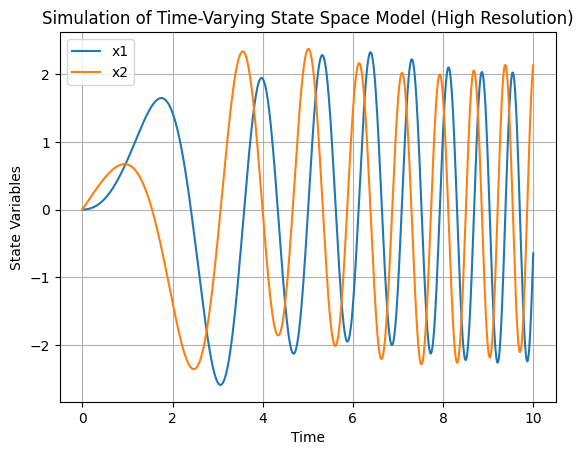

In [128]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define time-varying parameters A(t) and B(t) (as functions)
def A(t):
    return np.array([[0, t], [-t, 0]])  # Example time-varying state matrix

def B(t):
    return np.array([[np.sin(t)], [np.cos(t)]])  # Example time-varying input matrix

# Define the state space model dx/dt = A(t) * x + B(t) * u
def system(t, x):
    return np.dot(A(t), x).flatten() + np.dot(B(t), u(t)).flatten()

# Define the input function u(t) (for example, a step input)
def u(t):
    return 1 if t >= 0 else 0  # Step input at t=0

# Initial condition
x0 = np.array([0, 0])

# Time span for simulation
t_span = (0, 10)  # From t=0 to t=10

# Number of time points for simulation (increase for higher resolution)
num_points = 1000

# Time points for simulation
t_eval = np.linspace(t_span[0], t_span[1], num_points)

# Simulate the system using solve_ivp with specified time points
sol = solve_ivp(system, t_span, x0, t_eval=t_eval)

# Plot the results
plt.plot(sol.t, sol.y.T)
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.legend(['x1', 'x2'])
plt.title('Simulation of Time-Varying State Space Model (High Resolution)')
plt.grid(True)
plt.show()
